# Chapter 07
- SageMaker에 내장된 k-means 알고리즘을 사용하여 모델 구축, 학습 배포를 진행해 본다.
- k-means 알고리즘 : 클러스터링 알고리즘
<img src="./images/k-means.png" alt="Neural" style="height: 200px;"/>
### 1) 세팅

In [4]:
from sagemaker import get_execution_role # 생성했던 IAM 역할 호출

role = get_execution_role()
bucket='amathon-seon-s3' # s3 이름 입력

In [5]:
%%time
import pickle, gzip, numpy, urllib.request, json

# MNIST Dataset 다운로드
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1') # 바로 불러오기까지 진행

CPU times: user 896 ms, sys: 308 ms, total: 1.2 s
Wall time: 6.8 s


- Valid set : 모델을 개선하는데 사용, 성능평가
- Test set : 모델을 테스트 하는데 사용, 최종평가
<img src="./images/validation.png" alt="Neural" style="height: 150px;"/>

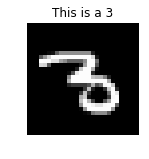

In [6]:
# 이미지를 하나 가져와서 데이터 확인
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (2,10)


def show_digit(img, caption='', subplot=None):
    if subplot==None:
        _,(subplot)=plt.subplots(1,1)
    imgr=img.reshape((28,28))
    subplot.axis('off')
    subplot.imshow(imgr, cmap='gray')
    plt.title(caption)

show_digit(train_set[0][30], 'This is a {}'.format(train_set[1][30]))

### 2) 모델 훈련

In [9]:
from sagemaker import KMeans # SageMaker에 내장되어있는 kmeans 알고리즘 불러오기.

data_location = 's3://{}/kmeans/data'.format(bucket) # 위에서 저장한 training 데이터 위치
output_location = 's3://{}/kmeans_model/output'.format(bucket) # 모델이 저장될 위치

print('training data will be uploaded to: {}'.format(data_location))
print('training artifacts will be uploaded to: {}'.format(output_location))

kmeans = KMeans(role=role, # IAM 역할
                train_instance_count=2, # 모델 훈련에 사용할 인스턴스 유형과 수
                train_instance_type='ml.c4.8xlarge',
                output_path=output_location, # 훈련 모델 저장 위치
                k=10, # 생성할 클러스터의 숫자
                data_location=data_location) # Training 데이터의 위치

training data will be uploaded to: s3://amathon-seon-s3/kmeans/data
training artifacts will be uploaded to: s3://amathon-seon-s3/kmeans_model/output


In [12]:
%%time
# 훈련시작
kmeans.fit(kmeans.record_set(train_set[0]))

INFO:sagemaker:Creating training-job with name: kmeans-2018-07-18-21-16-51-938


....................
Docker entrypoint called with argument(s): train
Docker entrypoint called with argument(s): train
[07/18/2018 21:20:03 INFO 139731077621568] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'eval_metrics': u'["msd"]', u'_num_kv_servers': u'1', u'mini_batch_size': u'5000', u'half_life_time_size': u'0', u'_num_slices': u'1'}
[07/18/2018 21:20:03 INFO 139731077621568] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'784', u'k': u'10', u'force_dense': u'True'}
[07/18/2018 21:20:03 INFO 139

===== Job Complete =====
Billable seconds: 206
CPU times: user 7.64 s, sys: 468 ms, total: 8.11 s
Wall time: 3min 51s


### 3) 모델 배포

In [13]:
%%time
## 엔드포인트 객체 반환
kmeans_predictor = kmeans.deploy(initial_instance_count=1, # 배포에 사용할 인스턴스 숫자와 타입
                                 instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: kmeans-2018-07-18-21-21-19-404
INFO:sagemaker:Creating endpoint with name kmeans-2018-07-18-21-16-51-938


--------------------------------------------------------------!CPU times: user 280 ms, sys: 16 ms, total: 296 ms
Wall time: 5min 13s


### 4) 모델 검증




Cluster 0:


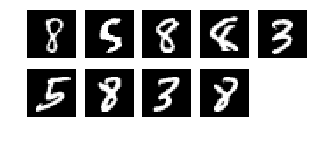




Cluster 1:


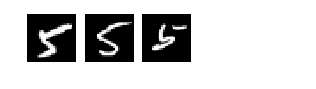




Cluster 2:


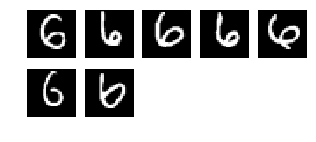




Cluster 3:


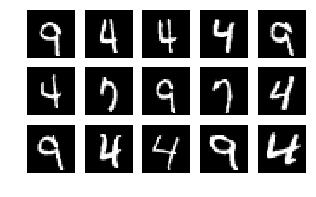




Cluster 4:


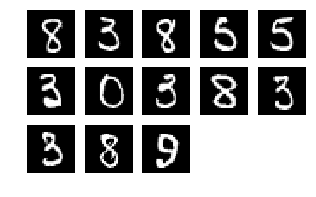




Cluster 5:


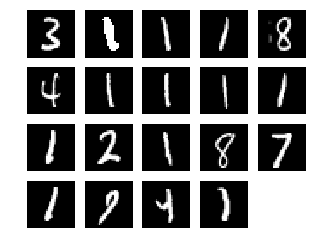




Cluster 6:


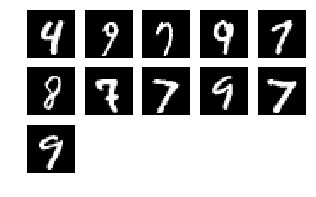




Cluster 7:


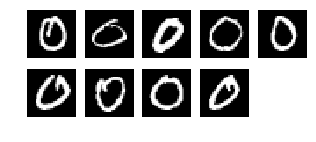




Cluster 8:


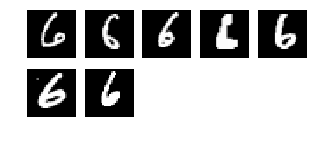




Cluster 9:


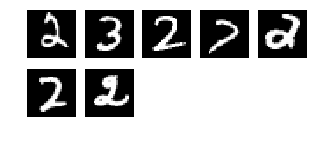

CPU times: user 4.02 s, sys: 1.67 s, total: 5.68 s
Wall time: 3.8 s


In [14]:
%%time 

result = kmeans_predictor.predict(valid_set[0][0:100])
clusters = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]

for cluster in range(10):
    print('\n\n\nCluster {}:'.format(int(cluster)))
    digits = [ img for l, img in zip(clusters, valid_set[0]) if int(l) == cluster ]
    height=((len(digits)-1)//5)+1
    width=5
    plt.rcParams["figure.figsize"] = (width,height)
    _, subplots = plt.subplots(height, width)
    subplots=numpy.ndarray.flatten(subplots)
    for subplot, image in zip(subplots, digits):
        show_digit(image, subplot=subplot)
    for subplot in subplots[len(digits):]:
        subplot.axis('off')

    plt.show()

### 5) Python 사용 예제

In [ ]:
# 안돌아가요.
import json

# Simple function to create a csv from our numpy array
def np2csv(arr):
    csv = io.BytesIO()
    numpy.savetxt(csv, arr, delimiter=',', fmt='%g')
    return csv.getvalue().decode().rstrip()

runtime = boto3.Session().client('sagemaker-runtime')

payload = np2csv(train_set[0][30:31])

response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='text/csv', 
                                   Body=payload)
result = json.loads(response['Body'].read().decode())
print(result)

### 6) 삭제
1. SageMaker 엔드포인트 삭제
2. 엔드포인트 삭제
3. 모델 삭제
5. 노트북 인스턴스 중지 및 삭제
6. S3 버킷 삭제
7. IAM 역할 삭제
8. Amazon CloudWatch에서 이름이 /aws/sagemaker/로 시작하는 모든 로그 그룹을 삭제합니다.